<a href="https://colab.research.google.com/github/Humble-LiuAo/ML-2021/blob/main/code/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 5 - Sequence-to-sequence**

If you have any questions, feel free to email us at: ntu-ml-2021spring-ta@googlegroups.com

### (4/21 Updates)
1. Link to reference [training curves](https://wandb.ai/george0828zhang/hw5.seq2seq.new).

### (4/14 Updates) 
1. Link to tutorial video [part 1](https://youtu.be/1pjS5_L5REI) [part 2](https://youtu.be/3XX9d0ymKgQ).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence Introduction
- Typical sequence-to-sequence (seq2seq) models are encoder-decoder models, which usually consists of two parts, the encoder and decoder, respectively. These two parts can be implemented with recurrent neural network (RNN) or transformer, primarily to deal with input/output sequences of dynamic length.
- **Encoder** encodes a sequence of inputs, such as text, video or audio, into a single vector, which can be viewed as the abstractive representation of the inputs, containing information of the whole sequence.
- **Decoder** decodes the vector output of encoder one step at a time, until the final output sequence is complete. Every decoding step is affected by previous step(s). Generally, one would add "< BOS >" at the begining of the sequence to indicate start of decoding, and "< EOS >" at the end to indicate end of decoding.

![seq2seq](https://i.imgur.com/0zeDyuI.png)

# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

# Download and import required packages

In [ ]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

     |████████████████████████████████| 90 kB 4.1 MB/s 
     |████████████████████████████████| 895 kB 30.9 MB/s 
     |████████████████████████████████| 1.2 MB 48.4 MB/s 
     |████████████████████████████████| 1.7 MB 55.1 MB/s 
     |████████████████████████████████| 97 kB 7.2 MB/s 
     |████████████████████████████████| 139 kB 58.0 MB/s 
     |████████████████████████████████| 180 kB 58.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=ce7cf054a574b4ba3e9f620395063515ae14ee9e17cfbb871e93ab23948e2895
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=9ab172851fbf3b4099bb0c1b6d2b87f470a50a743ad9a860e3171f3ffd7e3a5d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully

In [ ]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Cloning into 'fairseq'...
remote: Enumerating objects: 29781, done.
remote: Counting objects: 100% (862/862), done.
remote: Compressing objects: 100% (539/539), done.
remote: Total 29781 (delta 377), reused 697 (delta 308), pack-reused 28919
Receiving objects: 100% (29781/29781), 13.71 MiB | 20.34 MiB/s, done.
Resolving deltas: 100% (22106/22106), done.
Note: checking out '9a1c497'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary dir

In [ ]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [ ]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset Information

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

# Dataset Download

## Install megatools (optional)

In [ ]:
#!apt-get install megatools

## Download and extract

In [ ]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    # '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    # '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
    "https://drive.google.com/file/d/1Z7WVaXsj98gB8bXZvzsCDgiHGj2puuv0/view?usp=sharing",
    "https://drive.google.com/file/d/1Z7WVaXsj98gB8bXZvzsCDgiHGj2puuv0/view?usp=sharing",
# If the above links die, use the following instead. 
    # "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
    # "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

raw.en
raw.zh
test.en
test.zh


## Language

In [ ]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [ ]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [ ]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [ ]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/content/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/content/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [ ]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


In [ ]:
line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
line_num

393980

## Split into train/valid

In [ ]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [ ]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [ ]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/content/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [ ]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/content/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/content/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/content/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/content/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.


In [ ]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq

In [ ]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for Experiments

In [ ]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [ ]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environment

In [ ]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-10-27 08:29:08 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-10-27 08:29:08 | INFO | fairseq.utils | rank   0: capabilities =  6.0  ; total memory = 15.899 GB ; name = Tesla P100-PCIE-16GB                    
2021-10-27 08:29:08 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [ ]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-10-27 08:29:11 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2021-10-27 08:29:11 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-10-27 08:29:13 | INFO | hw5.seq2seq | loading data for epoch 1
2021-10-27 08:29:13 | INFO | fairseq.data.data_utils | loaded 390,829 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-10-27 08:29:13 | INFO | fairseq.data.data_utils | loaded 390,829 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-10-27 08:29:13 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390829 examples
2021-10-27 08:29:13 | INFO | fairseq.data.data_utils | loaded 3,151 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-10-27 08:29:13 | INFO | fairseq.data.data_utils | loaded 3,151 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-10-27 08:29:13 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3151 examples


In [ ]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 579,   45,  190, 1811,  885,    9, 2490,  389, 3628,   72,  159, 2943,
          96,   49, 2500, 1545,   50, 1019,    9, 1631,  190,   49,  263,  526,
           9, 1759,  120, 1261,    4,    5, 1226, 3900,    4,    5,  474,  372,
         145,    2]),
 'target': tensor([ 133,   12,  621,  207, 2773,  464, 2248,   89,  406,   57,   31,   13,
         105,    6,  311,  540, 1818,    4,   22,  135,    6,   16,  245,  540,
          27,   13, 1705,   57,   27,  388,  194,    6,  147,   59,  221,   39,
         108,  138, 1094,   83,  658, 1328,  657,  332,    4,  138,  245,  181,
           5,  847,  261,    7,    2])}
'Source: 現在我把神經生物的物質加插到這個模型中我們建造了一個一維的空間把我們心愛的實驗對象 , 果蠅 , 放進去'
('Target: now to put some neurobiological meat on this abstract model , we '
 'constructed a simple onedimensional world for our favorite subject , fruit '
 'flies .')


## Dataset Iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [ ]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-10-27 08:29:22 | WARNING | fairseq.tasks.fairseq_task | 2,004 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[2824, 427, 61, 2311, 515, 793, 951, 2890, 2740, 2418]


{'id': tensor([1853, 1971]),
 'net_input': {'prev_output_tokens': tensor([[   2,   22,   56, 1612,    7,    1,    1,    1],
          [   2,  375, 2801,   42,   33,    1,    1,    1]]),
  'src_lengths': tensor([9, 9]),
  'src_tokens': tensor([[   1,    1,    1,    1,    1,    1,    1,    5,  475,  233, 1112, 1163,
            582,   96,   10,    2],
          [   1,    1,    1,    1,    1,    1,    1,    5, 1048,  237, 3059,  914,
            992,  624,   33,    2]])},
 'nsentences': 2,
 'ntokens': 10,
 'target': tensor([[  22,   56, 1612,    7,    2,    1,    1,    1],
         [ 375, 2801,   42,   33,    2,    1,    1,    1]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [ ]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder

- The Encoder is a RNN or Transformer Encoder. The following description is for RNN. For every input token, Encoder will generate a output vector and a hidden states vector, and the hidden states vector is passed on to the next step. In other words, the Encoder sequentially reads in the input sequence, and outputs a single vector at each timestep, then finally outputs the final hidden states, or content vector, at the last timestep.
- Parameters:
  - *args*
      - encoder_embed_dim: the dimension of embeddings, this compresses the one-hot vector into fixed dimensions, which achieves dimension reduction
      - encoder_ffn_embed_dim is the dimension of hidden states and output vectors
      - encoder_layers is the number of layers for Encoder RNN
      - dropout determines the probability of a neuron's activation being set to 0, in order to prevent overfitting. Generally this is applied in training, and removed in testing.
  - *dictionary*: the dictionary provided by fairseq. it's used to obtain the padding index, and in turn the encoder padding mask. 
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)

- Inputs: 
    - *src_tokens*: integer sequence representing english e.g. 1, 28, 29, 205, 2 
- Outputs: 
    - *outputs*: the output of RNN at each timestep, can be furthur processed by Attention
    - *final_hiddens*: the hidden states of each timestep, will be passed to decoder for decoding
    - *encoder_padding_mask*: this tells the decoder which position to ignore


In [ ]:
class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
        
        # get embeddings
        x = self.embed_tokens(src_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
        
        # pass thru bidirectional RNN
        h0 = x.new_zeros(2 * self.num_layers, bsz, self.hidden_dim)
        x, final_hiddens = self.rnn(x, h0)
        outputs = self.dropout_out_module(x)
        # outputs = [sequence len, batch size, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        
        # Since Encoder is bidirectional, we need to concatenate the hidden states of two directions
        final_hiddens = self.combine_bidir(final_hiddens, bsz)
        # hidden =  [num_layers x batch x num_directions*hidden]
        
        encoder_padding_mask = src_tokens.eq(self.padding_idx).t()
        return tuple(
            (
                outputs,  # seq_len x batch x hidden
                final_hiddens,  # num_layers x batch x num_directions*hidden
                encoder_padding_mask,  # seq_len x batch
            )
        )
    
    def reorder_encoder_out(self, encoder_out, new_order):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        return tuple(
            (
                encoder_out[0].index_select(1, new_order),
                encoder_out[1].index_select(1, new_order),
                encoder_out[2].index_select(1, new_order),
            )
        )

## Attention

- When the input sequence is long, "content vector" alone cannot accurately represent the whole sequence, attention mechanism can provide the Decoder more information.
- According to the **Decoder embeddings** of the current timestep, match the **Encoder outputs** with decoder embeddings to determine correlation, and then sum the Encoder outputs weighted by the correlation as the input to **Decoder** RNN.
- Common attention implementations use neural network / dot product as the correlation between **query** (decoder embeddings) and **key** (Encoder outputs), followed by **softmax**  to obtain a distribution, and finally **values** (Encoder outputs) is **weighted sum**-ed by said distribution.

- Parameters:
  - *input_embed_dim*: dimensionality of key, should be that of the vector in decoder to attend others
  - *source_embed_dim*: dimensionality of query, should be that of the vector to be attended to (encoder outputs)
  - *output_embed_dim*: dimensionality of value, should be that of the vector after attention, expected by the next layer

- Inputs: 
    - *inputs*: is the key, the vector to attend to others
    - *encoder_outputs*:  is the query/value, the vector to be attended to
    - *encoder_padding_mask*: this tells the decoder which position to ignore
- Outputs: 
    - *output*: the context vector after attention
    - *attention score*: the attention distribution


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # project to the dimensionality of encoder_outputs
        x = self.input_proj(inputs)

        # compute attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # cancel the attention at positions corresponding to padding
        if encoder_padding_mask is not None:
            # leveraging broadcast  B, S -> (B, 1, S)
            encoder_padding_mask = encoder_padding_mask.unsqueeze(1)
            attn_scores = (
                attn_scores.float()
                .masked_fill_(encoder_padding_mask, float("-inf"))
                .type_as(attn_scores)
            )  # FP16 support: cast to float and back

        # softmax on the dimension corresponding to source sequence
        attn_scores = F.softmax(attn_scores, dim=-1)

        # shape (B, T, S) x (B, S, dim) = (B, T, dim) weighted sum
        x = torch.bmm(attn_scores, encoder_outputs)

        # (B, T, dim)
        x = torch.cat((x, inputs), dim=-1)
        x = torch.tanh(self.output_proj(x)) # concat + linear + tanh
        
        # restore shape (B, T, dim) -> (T, B, dim)
        return x.transpose(1,0), attn_scores

## Decoder

* The hidden states of **Decoder** will be initialized by the final hidden states of **Encoder** (the content vector)
* At the same time, **Decoder** will change its hidden states based on the input of the current timestep (the outputs of previous timesteps), and generates an output
* Attention improves the performance
* The seq2seq steps are implemented in decoder, so that later the Seq2Seq class can accept RNN and Transformer, without furthur modification.
- Parameters:
  - *args*
      - decoder_embed_dim: is the dimensionality of the decoder embeddings, similar to encoder_embed_dim，
      - decoder_ffn_embed_dim: is the dimensionality of the decoder RNN hidden states, similar to encoder_ffn_embed_dim
      - decoder_layers: number of layers of RNN decoder
      - share_decoder_input_output_embed: usually, the projection matrix of the decoder will share weights with the decoder input embeddings
  - *dictionary*: the dictionary provided by fairseq
  - *embed_tokens*: an instance of token embeddings (nn.Embedding)
- Inputs: 
    - *prev_output_tokens*: integer sequence representing the right-shifted target e.g. 1, 28, 29, 205, 2 
    - *encoder_out*: encoder's output.
    - *incremental_state*: in order to speed up decoding during test time, we will save the hidden state of each timestep. see forward() for details.
- Outputs: 
    - *outputs*: the logits (before softmax) output of decoder for each timesteps
    - *extra*: unsused

In [ ]:
class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=False
        )
        self.attention = AttentionLayer(
            self.embed_dim, self.hidden_dim, self.embed_dim, bias=False
        ) 
        # self.attention = None
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        if self.hidden_dim != self.embed_dim:
            self.project_out_dim = nn.Linear(self.hidden_dim, self.embed_dim)
        else:
            self.project_out_dim = None
        
        if args.share_decoder_input_output_embed:
            self.output_projection = nn.Linear(
                self.embed_tokens.weight.shape[1],
                self.embed_tokens.weight.shape[0],
                bias=False,
            )
            self.output_projection.weight = self.embed_tokens.weight
        else:
            self.output_projection = nn.Linear(
                self.output_embed_dim, len(dictionary), bias=False
            )
            nn.init.normal_(
                self.output_projection.weight, mean=0, std=self.output_embed_dim ** -0.5
            )
        
    def forward(self, prev_output_tokens, encoder_out, incremental_state=None, **unused):
        # extract the outputs from encoder
        encoder_outputs, encoder_hiddens, encoder_padding_mask = encoder_out
        # outputs:          seq_len x batch x num_directions*hidden
        # encoder_hiddens:  num_layers x batch x num_directions*encoder_hidden
        # padding_mask:     seq_len x batch
        
        if incremental_state is not None and len(incremental_state) > 0:
            # if the information from last timestep is retained, we can continue from there instead of starting from bos
            prev_output_tokens = prev_output_tokens[:, -1:]
            cache_state = self.get_incremental_state(incremental_state, "cached_state")
            prev_hiddens = cache_state["prev_hiddens"]
        else:
            # incremental state does not exist, either this is training time, or the first timestep of test time
            # prepare for seq2seq: pass the encoder_hidden to the decoder hidden states
            prev_hiddens = encoder_hiddens
        
        bsz, seqlen = prev_output_tokens.size()
        
        # embed tokens
        x = self.embed_tokens(prev_output_tokens)
        x = self.dropout_in_module(x)

        # B x T x C -> T x B x C
        x = x.transpose(0, 1)
                
        # decoder-to-encoder attention
        if self.attention is not None:
            x, attn = self.attention(x, encoder_outputs, encoder_padding_mask)
                        
        # pass thru unidirectional RNN
        x, final_hiddens = self.rnn(x, prev_hiddens)
        # outputs = [sequence len, batch size, hid dim]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        x = self.dropout_out_module(x)
                
        # project to embedding size (if hidden differs from embed size, and share_embedding is True, 
        # we need to do an extra projection)
        if self.project_out_dim != None:
            x = self.project_out_dim(x)
        
        # project to vocab size
        x = self.output_projection(x)
        
        # T x B x C -> B x T x C
        x = x.transpose(1, 0)
        
        # if incremental, record the hidden states of current timestep, which will be restored in the next timestep
        cache_state = {
            "prev_hiddens": final_hiddens,
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        
        return x, None
    
    def reorder_incremental_state(
        self,
        incremental_state,
        new_order,
    ):
        # This is used by fairseq's beam search. How and why is not particularly important here.
        cache_state = self.get_incremental_state(incremental_state, "cached_state")
        prev_hiddens = cache_state["prev_hiddens"]
        prev_hiddens = [p.index_select(0, new_order) for p in prev_hiddens]
        cache_state = {
            "prev_hiddens": torch.stack(prev_hiddens),
        }
        self.set_incremental_state(incremental_state, "cached_state", cache_state)
        return

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [ ]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [ ]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration
reference implementation

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [ ]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [ ]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

2021-10-27 08:29:44 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bia

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [ ]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## Scheduling Visualized

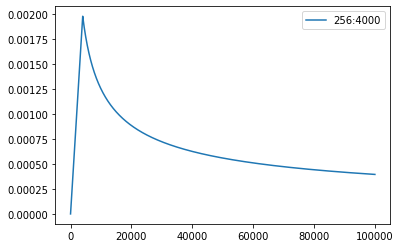

In [ ]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [ ]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [ ]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [ ]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights

In [ ]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [ ]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [ ]:
!nvidia-smi

Wed Oct 27 08:30:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    35W / 250W |   1021MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-10-27 08:30:43 | INFO | hw5.seq2seq | task: TranslationTask
2021-10-27 08:30:43 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-10-27 08:30:43 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-10-27 08:30:43 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-10-27 08:30:43 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-10-27 08:30:43 | INFO | hw5.seq2seq | num. model params: 11,469,824 (num. trained: 11,469,824)
2021-10-27 08:30:43 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-10-27 03:18:05 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[327321]
2021-10-27 03:18:05 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/rnn/checkpoint_last.pt!


train epoch 1:   0%|          | 0/801 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


2021-10-27 03:22:40 | INFO | hw5.seq2seq | training loss: 6.2410
2021-10-27 03:22:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


2021-10-27 03:22:58 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 03:22:58 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 03:22:58 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 03:22:58 | INFO | hw5.seq2seq | example source: 這詞兒挺怪 , 但他也算是這樣的人 。
2021-10-27 03:22:58 | INFO | hw5.seq2seq | example hypothesis: it's a lot of i'm going to do it .
2021-10-27 03:22:58 | INFO | hw5.seq2seq | example reference: strange term , but in some ways , he is .
2021-10-27 03:22:58 | INFO | hw5.seq2seq | validation loss:	4.9365
2021-10-27 03:22:58 | INFO | hw5.seq2seq | BLEU = 1.01 24.0/2.5/0.4/0.1 (BP = 0.868 ratio = 0.876 hyp_len = 53836 ref_len = 61470)
2021-10-27 03:22:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint1.pt
2021-10-27 03:22:59 | INFO | hw5.

train epoch 2:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 03:27:33 | INFO | hw5.seq2seq | training loss: 4.6216
2021-10-27 03:27:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 03:27:51 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 03:27:51 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 03:27:51 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 03:27:51 | INFO | hw5.seq2seq | example source: 但是變得還不夠快 。
2021-10-27 03:27:51 | INFO | hw5.seq2seq | example hypothesis: but it's not easy .
2021-10-27 03:27:51 | INFO | hw5.seq2seq | example reference: but it just isn't changing fast enough .
2021-10-27 03:27:51 | INFO | hw5.seq2seq | validation loss:	4.1007
2021-10-27 03:27:51 | INFO | hw5.seq2seq | BLEU = 5.22 36.9/10.1/3.5/1.2 (BP = 0.826 ratio = 0.839 hyp_len = 51585 ref_len = 61470)
2021-10-27 03:27:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint2.pt
2021-10-27 03:27:51 | INFO | hw5.seq2seq | end of epoch 2

train epoch 3:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 03:32:25 | INFO | hw5.seq2seq | training loss: 4.0414
2021-10-27 03:32:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 03:32:44 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 03:32:44 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 03:32:44 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 03:32:44 | INFO | hw5.seq2seq | example source: 我這麼做總會讓她們很開心 。
2021-10-27 03:32:44 | INFO | hw5.seq2seq | example hypothesis: i'm going to make them happy .
2021-10-27 03:32:44 | INFO | hw5.seq2seq | example reference: they're always happy when i do that .
2021-10-27 03:32:44 | INFO | hw5.seq2seq | validation loss:	3.6414
2021-10-27 03:32:44 | INFO | hw5.seq2seq | BLEU = 8.66 44.3/15.4/6.5/2.8 (BP = 0.819 ratio = 0.834 hyp_len = 51239 ref_len = 61470)
2021-10-27 03:32:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint3.pt
2021-10-27 03:32:44 | INFO | hw5.seq2seq | en

train epoch 4:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 03:37:17 | INFO | hw5.seq2seq | training loss: 3.7276
2021-10-27 03:37:17 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 03:37:36 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 03:37:36 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 03:37:36 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 03:37:36 | INFO | hw5.seq2seq | example source: 那是第一次 , 石牆暴動的故事得到全國人民關注 。
2021-10-27 03:37:36 | INFO | hw5.seq2seq | example hypothesis: and that's the first time , the story of the fossil walls are focused .
2021-10-27 03:37:36 | INFO | hw5.seq2seq | example reference: it was the first time the story of stonewall had been told to a national audience .
2021-10-27 03:37:36 | INFO | hw5.seq2seq | validation loss:	3.4071
2021-10-27 03:37:36 | INFO | hw5.seq2seq | BLEU = 11.00 45.8/17.5/7.9/3.7 (BP = 0.890 ratio = 0.896 hyp_len = 55057 ref_len = 61470)
2021-10-27 03:37:36 | INFO | hw5.seq2seq | saved epoc

train epoch 5:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 03:42:10 | INFO | hw5.seq2seq | training loss: 3.5635
2021-10-27 03:42:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 03:42:28 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 03:42:28 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 03:42:28 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 03:42:28 | INFO | hw5.seq2seq | example source: 謝謝 。
2021-10-27 03:42:28 | INFO | hw5.seq2seq | example hypothesis: thank you .
2021-10-27 03:42:28 | INFO | hw5.seq2seq | example reference: thank you .
2021-10-27 03:42:28 | INFO | hw5.seq2seq | validation loss:	3.2871
2021-10-27 03:42:28 | INFO | hw5.seq2seq | BLEU = 11.94 47.6/18.9/8.8/4.2 (BP = 0.884 ratio = 0.890 hyp_len = 54737 ref_len = 61470)
2021-10-27 03:42:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint5.pt
2021-10-27 03:42:29 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 03:47:03 | INFO | hw5.seq2seq | training loss: 3.4438
2021-10-27 03:47:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 03:47:21 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 03:47:21 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 03:47:21 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 03:47:21 | INFO | hw5.seq2seq | example source: 謝謝 。
2021-10-27 03:47:21 | INFO | hw5.seq2seq | example hypothesis: thank you .
2021-10-27 03:47:21 | INFO | hw5.seq2seq | example reference: thank you .
2021-10-27 03:47:21 | INFO | hw5.seq2seq | validation loss:	3.2040
2021-10-27 03:47:21 | INFO | hw5.seq2seq | BLEU = 12.19 51.9/21.6/10.5/5.2 (BP = 0.774 ratio = 0.796 hyp_len = 48934 ref_len = 61470)
2021-10-27 03:47:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint6.pt
2021-10-27 03:47:21 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 03:51:55 | INFO | hw5.seq2seq | training loss: 3.3390
2021-10-27 03:51:55 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 03:52:12 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 03:52:12 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 03:52:12 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 03:52:12 | INFO | hw5.seq2seq | example source: 我在他們的身上學到好多 , 愛、同情心、想像力 , 以及創造力 。
2021-10-27 03:52:12 | INFO | hw5.seq2seq | example hypothesis: i learned a lot better about love , empathy , imagination and creativity .
2021-10-27 03:52:12 | INFO | hw5.seq2seq | example reference: i've learned so much from them: love , compassion , imagination and such creativity .
2021-10-27 03:52:12 | INFO | hw5.seq2seq | validation loss:	3.1486
2021-10-27 03:52:12 | INFO | hw5.seq2seq | BLEU = 12.15 54.4/23.0/11.3/5.8 (BP = 0.718 ratio = 0.751 hyp_len = 46186 ref_len = 61470)
2021-10-27 03:52:12 | INFO | hw5.seq2se

train epoch 8:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 03:56:46 | INFO | hw5.seq2seq | training loss: 3.2655
2021-10-27 03:56:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 03:57:05 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 03:57:05 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 03:57:05 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 03:57:05 | INFO | hw5.seq2seq | example source: 這是玻利維亞的一間酒店
2021-10-27 03:57:05 | INFO | hw5.seq2seq | example hypothesis: this is a wine store in bolivia .
2021-10-27 03:57:05 | INFO | hw5.seq2seq | example reference: this is a hotel in bolivia .
2021-10-27 03:57:05 | INFO | hw5.seq2seq | validation loss:	3.0676
2021-10-27 03:57:05 | INFO | hw5.seq2seq | BLEU = 14.63 53.0/22.9/11.5/5.9 (BP = 0.862 ratio = 0.870 hyp_len = 53502 ref_len = 61470)
2021-10-27 03:57:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint8.pt
2021-10-27 03:57:05 | INFO | hw5.seq2seq | end of ep

train epoch 9:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:01:39 | INFO | hw5.seq2seq | training loss: 3.2093
2021-10-27 04:01:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:01:57 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:01:57 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:01:57 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:01:57 | INFO | hw5.seq2seq | example source: 如果你為你的死亡做規劃 , 還存活的人就知道如何度過一段健康的喪親/友之痛 , 不用害怕或有罪惡感 , 覺得沒有尊重你的傳承 。
2021-10-27 04:01:57 | INFO | hw5.seq2seq | example hypothesis: if you plan for your death , the survivor knows how to overload a healthy dear or a criminal survivor .
2021-10-27 04:01:57 | INFO | hw5.seq2seq | example reference: so if you plan for your death , then your survivors will know how to experience a healthy bereavement without fear or guilt of having failed to honor your legacy .
2021-10-27 04:01:57 | INFO | hw5.seq2seq | validation loss:	3.0362
2021-10-27 04:01:57 | INFO | hw5.se

train epoch 10:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:06:31 | INFO | hw5.seq2seq | training loss: 3.1663
2021-10-27 04:06:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:06:50 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:06:50 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:06:50 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:06:50 | INFO | hw5.seq2seq | example source: 但是每一個音樂家在信念與邏輯 , 直覺和智慧間 , 會取得不同的平衡點 。
2021-10-27 04:06:50 | INFO | hw5.seq2seq | example hypothesis: but every musician is getting a different balance between ideas and logics and intuition and intelligence .
2021-10-27 04:06:50 | INFO | hw5.seq2seq | example reference: but every musician strikes a different balance between faith and reason , instinct and intelligence .
2021-10-27 04:06:50 | INFO | hw5.seq2seq | validation loss:	2.9947
2021-10-27 04:06:50 | INFO | hw5.seq2seq | BLEU = 15.63 51.5/22.7/11.5/6.1 (BP = 0.925 ratio = 0.928 hyp_len = 57020 ref

train epoch 11:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:11:25 | INFO | hw5.seq2seq | training loss: 3.1333
2021-10-27 04:11:25 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:11:43 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:11:43 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:11:43 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:11:43 | INFO | hw5.seq2seq | example source: 但我很高興我做了 , 因為那時 , 你開始開發鱷魚皮膚 , 特別是當你是實驗室中的女性 , 在做不同的事 。
2021-10-27 04:11:43 | INFO | hw5.seq2seq | example hypothesis: but i'm glad that i did , because then you started developing crocodile skin , especially when you were women in the lab , doing different things .
2021-10-27 04:11:43 | INFO | hw5.seq2seq | example reference: but i'm glad i did , because by that time , you start developing a crocodile skin , especially when you're a woman in the lab doing different things .
2021-10-27 04:11:43 | INFO | hw5.seq2seq | validation loss:	2.9705
2021-10-27 04:

train epoch 12:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:16:18 | INFO | hw5.seq2seq | training loss: 3.1044
2021-10-27 04:16:18 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:16:36 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:16:36 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:16:36 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:16:36 | INFO | hw5.seq2seq | example source: 他們仔細探究了他們收集到的大量資料 , 試圖想要找出是什麼因素讓人生開端很困苦的孩童能繼續走下去並在學校表現出色 。
2021-10-27 04:16:36 | INFO | hw5.seq2seq | example hypothesis: they looked carefully explored the amount of data that they collected , trying to figure out what causes people were creating , and they could continue to go down and perform in schools .
2021-10-27 04:16:36 | INFO | hw5.seq2seq | example reference: they sifted all the mountains of data that they had collected to try to work out what allowed the children who'd had a difficult start in life to go on and do well at school nevertheless .

train epoch 13:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:21:10 | INFO | hw5.seq2seq | training loss: 3.0779
2021-10-27 04:21:10 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:21:29 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:21:29 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:21:29 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:21:29 | INFO | hw5.seq2seq | example source: 我認為這個工具將比跨州公路法案來得更強大 , 對我們的電子化經濟更是重要 , 也會改變整個世界 。
2021-10-27 04:21:29 | INFO | hw5.seq2seq | example hypothesis: i think that this tool is going to be much stronger than the state road project , and it's more important to our electronic economy , and it changes the whole world .
2021-10-27 04:21:29 | INFO | hw5.seq2seq | example reference: i think this is a more powerful tool than the interstate highway act , and i think this is as important and world changing to our economy as electrification .
2021-10-27 04:21:29 | INFO | hw5.seq2seq | validation loss:

train epoch 14:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:26:03 | INFO | hw5.seq2seq | training loss: 3.0560
2021-10-27 04:26:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:26:21 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:26:21 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:26:21 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:26:21 | INFO | hw5.seq2seq | example source: 他名叫西蒙.顧志耐他提交的報告則稱為 「 國家收入:1929-1932年 」
2021-10-27 04:26:21 | INFO | hw5.seq2seq | example hypothesis: his name is simon's volunteer , who says , " national income in 1929 in 1932 . "
2021-10-27 04:26:21 | INFO | hw5.seq2seq | example reference: his name was simon kuznets and the report that he delivered was called " national income , 19291932 . "
2021-10-27 04:26:21 | INFO | hw5.seq2seq | validation loss:	2.9172
2021-10-27 04:26:21 | INFO | hw5.seq2seq | BLEU = 16.18 54.8/24.9/13.0/7.0 (BP = 0.863 ratio = 0.872 hyp_len = 53575 ref_len = 61470)
2021-10-27

train epoch 15:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:30:56 | INFO | hw5.seq2seq | training loss: 3.0375
2021-10-27 04:30:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:31:15 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:31:15 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:31:15 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:31:15 | INFO | hw5.seq2seq | example source: 這是無線感應器科技的其中一個應用 。
2021-10-27 04:31:15 | INFO | hw5.seq2seq | example hypothesis: this is one of the applications of wireless sensors technology .
2021-10-27 04:31:15 | INFO | hw5.seq2seq | example reference: one of many different techniques using wireless sensors .
2021-10-27 04:31:15 | INFO | hw5.seq2seq | validation loss:	2.8937
2021-10-27 04:31:15 | INFO | hw5.seq2seq | BLEU = 16.95 52.3/23.7/12.4/6.7 (BP = 0.946 ratio = 0.948 hyp_len = 58259 ref_len = 61470)
2021-10-27 04:31:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/

train epoch 16:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:35:48 | INFO | hw5.seq2seq | training loss: 3.0228
2021-10-27 04:35:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:36:07 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:36:07 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:36:07 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:36:07 | INFO | hw5.seq2seq | example source: 我們稱之為脈衝星 。
2021-10-27 04:36:07 | INFO | hw5.seq2seq | example hypothesis: we call it the pulse .
2021-10-27 04:36:07 | INFO | hw5.seq2seq | example reference: we call those pulsars .
2021-10-27 04:36:07 | INFO | hw5.seq2seq | validation loss:	2.8840
2021-10-27 04:36:07 | INFO | hw5.seq2seq | BLEU = 16.57 54.8/25.2/13.4/7.4 (BP = 0.862 ratio = 0.871 hyp_len = 53528 ref_len = 61470)
2021-10-27 04:36:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint16.pt
2021-10-27 04:36:07 | INFO | hw5.seq2seq | end of epoch 16


train epoch 17:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:40:42 | INFO | hw5.seq2seq | training loss: 3.0073
2021-10-27 04:40:42 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:41:00 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:41:00 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:41:00 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:41:00 | INFO | hw5.seq2seq | example source: 當我們問到什麽是美好生活這可從我們設計的一切事物看出但爲什麽我們就只看到設計而不進一步問這設計如何能應用在我們的生活上 ?
2021-10-27 04:41:00 | INFO | hw5.seq2seq | example hypothesis: when we ask what's a wonderful life , it's all we designed , but why do we just see design instead of asking how this design can be applied to our lives ?
2021-10-27 04:41:00 | INFO | hw5.seq2seq | example reference: why , when the question of what the good life is informs everything that we design , should we stop at design and not ask ourselves: how does it apply to our own life ?
2021-10-27 04:41:00 | INFO | hw5.seq2seq | valida

train epoch 18:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:45:34 | INFO | hw5.seq2seq | training loss: 2.9954
2021-10-27 04:45:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:45:53 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:45:53 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:45:53 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:45:53 | INFO | hw5.seq2seq | example source: 如果把所有動物的基因算在一起 , 我們所共有的基因族群大概只有三萬不到一點 。
2021-10-27 04:45:53 | INFO | hw5.seq2seq | example hypothesis: if we calculate the genes of all animals , we share about 30 , 000 genetic groups .
2021-10-27 04:45:53 | INFO | hw5.seq2seq | example reference: and if you take all animals together , we probably share less than 30 , 000 and probably maybe a dozen or more thousand different gene families .
2021-10-27 04:45:53 | INFO | hw5.seq2seq | validation loss:	2.8682
2021-10-27 04:45:53 | INFO | hw5.seq2seq | BLEU = 16.61 55.8/25.9/13.8/7.6 (BP = 0.842 ratio = 0.8

train epoch 19:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:50:28 | INFO | hw5.seq2seq | training loss: 2.9837
2021-10-27 04:50:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:50:46 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:50:46 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:50:46 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:50:46 | INFO | hw5.seq2seq | example source: 是你發現人性還有發現真相的地方 。
2021-10-27 04:50:46 | INFO | hw5.seq2seq | example hypothesis: it's where you find humanity and find the truth .
2021-10-27 04:50:46 | INFO | hw5.seq2seq | example reference: it's where you find the humanity , and it's where you find the truth .
2021-10-27 04:50:46 | INFO | hw5.seq2seq | validation loss:	2.8593
2021-10-27 04:50:46 | INFO | hw5.seq2seq | BLEU = 16.75 55.4/25.5/13.6/7.5 (BP = 0.860 ratio = 0.869 hyp_len = 53421 ref_len = 61470)
2021-10-27 04:50:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/che

train epoch 20:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 04:55:20 | INFO | hw5.seq2seq | training loss: 2.9732
2021-10-27 04:55:20 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 04:55:39 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 04:55:39 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 04:55:39 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 04:55:39 | INFO | hw5.seq2seq | example source: 這是個很糟的情況 , 當你使用一項服務 , 理想情況下 , 只是想了解世界資訊 , 但你卻花了多數的時間於:檢舉或受到辱罵、被人騷擾 。
2021-10-27 04:55:39 | INFO | hw5.seq2seq | example hypothesis: it's a terrible situation when you use a service , the ideal situation is just trying to understand the world information , but you spend a lot of time examining or abused or harassed .
2021-10-27 04:55:39 | INFO | hw5.seq2seq | example reference: so it's a pretty terrible situation when you're coming to a service that , ideally , you want to learn something about the world , and you spend the majority of your time reporting

train epoch 21:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 05:00:12 | INFO | hw5.seq2seq | training loss: 2.9601
2021-10-27 05:00:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 05:00:31 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 05:00:31 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 05:00:31 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 05:00:31 | INFO | hw5.seq2seq | example source: 你看 , 不管在哪個國家你都會聽到武裝聖戰者針對平民百姓 , 也有很多手無寸鐵的人民公然反抗那些激進分子 , 只是你沒聽過 , 那些人需要我們的支持才能成功 。
2021-10-27 05:00:31 | INFO | hw5.seq2seq | example hypothesis: you see , anywhere in the country , you'll hear the armed jihadians on the civilians , and there's a lot of handless people who resist those radical molecules , but you haven't heard , those people need our support to succeed .
2021-10-27 05:00:31 | INFO | hw5.seq2seq | example reference: you see , in every country where you hear about armed jihadis targeting civilians , there are also unarmed people defying thos

train epoch 22:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 05:05:06 | INFO | hw5.seq2seq | training loss: 2.9525
2021-10-27 05:05:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 05:05:24 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 05:05:24 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 05:05:24 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 05:05:24 | INFO | hw5.seq2seq | example source: 可是為什麼我要去上學 ?
2021-10-27 05:05:24 | INFO | hw5.seq2seq | example hypothesis: but why am i going to school ?
2021-10-27 05:05:24 | INFO | hw5.seq2seq | example reference: but why do i have to go to school ?
2021-10-27 05:05:24 | INFO | hw5.seq2seq | validation loss:	2.8368
2021-10-27 05:05:24 | INFO | hw5.seq2seq | BLEU = 17.44 55.0/25.6/13.6/7.5 (BP = 0.895 ratio = 0.900 hyp_len = 55334 ref_len = 61470)
2021-10-27 05:05:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint22.pt
2021-10-27 05:05:25 | INFO | hw5.seq2seq | end

train epoch 23:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 05:10:00 | INFO | hw5.seq2seq | training loss: 2.9435
2021-10-27 05:10:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 05:10:18 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 05:10:18 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 05:10:18 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 05:10:19 | INFO | hw5.seq2seq | example source: 他們確保年輕的老師在工作時能夠有機會去觀摩大師級老師 。 他們確保年輕的老師在工作時能夠有機會去觀摩大師級老師 。
2021-10-27 05:10:19 | INFO | hw5.seq2seq | example hypothesis: they ensure that young teachers can have the opportunity to watch motor master teachers at work , and they ensure that young teachers can be able to go to the masters when they're working .
2021-10-27 05:10:19 | INFO | hw5.seq2seq | example reference: they made sure that younger teachers get a chance to watch master teachers at work .
2021-10-27 05:10:19 | INFO | hw5.seq2seq | validation loss:	2.8292
2021-10-27 05:10:19 | INFO | hw5.se

train epoch 24:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 05:14:53 | INFO | hw5.seq2seq | training loss: 2.9358
2021-10-27 05:14:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 05:15:12 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 05:15:12 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 05:15:12 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 05:15:12 | INFO | hw5.seq2seq | example source: 回饋:這一點更複雜尤其是大腦在整合訊息的狀態跟各種因素:外部環境、內在狀態我們的感受及其他因素等等 , 加總的影響
2021-10-27 05:15:12 | INFO | hw5.seq2seq | example hypothesis: feedback: it's much more complex , especially integrated integrated information and all kinds of factors: external environments , inner state , our feelings and other factors and so on .
2021-10-27 05:15:12 | INFO | hw5.seq2seq | example reference: reward: this is a more complex and especially integrative form of our brain with various different elements the external states , our internal states , how do we feel , and so on are put tog

train epoch 25:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 05:19:47 | INFO | hw5.seq2seq | training loss: 2.9291
2021-10-27 05:19:47 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 05:20:06 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 05:20:06 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 05:20:06 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 05:20:06 | INFO | hw5.seq2seq | example source: 你可能聽說過星聯玉米 , 尤其是一年半前當所有這些玉米糠皮被超市下架的時候 。
2021-10-27 05:20:06 | INFO | hw5.seq2seq | example hypothesis: you might have heard about star corn corn , especially a year and a half ago when all the corn chaffs were struggled under the supermarket .
2021-10-27 05:20:06 | INFO | hw5.seq2seq | example reference: you may of heard of it heard it called starlink , especially when all those taco shells were taken out of the supermarkets about a year and a half ago .
2021-10-27 05:20:06 | INFO | hw5.seq2seq | validation loss:	2.8200
2021-10-27 05:20:06 | INFO | hw5.s

train epoch 26:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 05:24:41 | INFO | hw5.seq2seq | training loss: 2.9230
2021-10-27 05:24:41 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 05:24:59 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 05:24:59 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 05:24:59 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 05:24:59 | INFO | hw5.seq2seq | example source: 要實行這個想法買台最便宜的烤麵包機就是最簡單的逆向操作我盡力去買了最便宜的烤麵包機帶回家後有點傻眼的發現這個東西裡面這個我才花3英鎊45便士買的東西竟然有400種不同的小零件由100多種材料所製成
2021-10-27 05:24:59 | INFO | hw5.seq2seq | example hypothesis: to do this idea , the cheapest barbecue machine is the simplest adversity manipulation , and i'm trying to buy the cheapest barbecue machine to bring back home a little bit of a silly discovery in this thing , which i've only spent three pounds of three pounds , 45 , 000 different components , which are made of 1 , 000 different materials .
2021-10-27 05:24:59 | INFO | hw5.seq2seq | example refe

train epoch 27:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 05:29:34 | INFO | hw5.seq2seq | training loss: 2.9160
2021-10-27 05:29:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 05:29:53 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 05:29:53 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 05:29:53 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 05:29:53 | INFO | hw5.seq2seq | example source: 寫出來、講出來、說出來 。
2021-10-27 05:29:53 | INFO | hw5.seq2seq | example hypothesis: write , speak out , say it .
2021-10-27 05:29:53 | INFO | hw5.seq2seq | example reference: what do you want your life to look like ?
2021-10-27 05:29:53 | INFO | hw5.seq2seq | validation loss:	2.8140
2021-10-27 05:29:53 | INFO | hw5.seq2seq | BLEU = 17.96 55.6/26.3/14.2/7.9 (BP = 0.895 ratio = 0.900 hyp_len = 55339 ref_len = 61470)
2021-10-27 05:29:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/checkpoints/rnn/checkpoint27.pt
2021-10-27 05:29:53 | INFO | hw5.seq2seq 

train epoch 28:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 05:34:28 | INFO | hw5.seq2seq | training loss: 2.9094
2021-10-27 05:34:28 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 05:34:46 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 05:34:46 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 05:34:46 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 05:34:46 | INFO | hw5.seq2seq | example source: 所以是能從海水提煉出有價值的元素像高性能電池需要的鋰
2021-10-27 05:34:46 | INFO | hw5.seq2seq | example hypothesis: so it's lithium that can extract valuable elements from seawater like high energy batteries .
2021-10-27 05:34:46 | INFO | hw5.seq2seq | example reference: so it should be possible to extract valuable elements like lithium for highperformance batteries .
2021-10-27 05:34:46 | INFO | hw5.seq2seq | validation loss:	2.8018
2021-10-27 05:34:46 | INFO | hw5.seq2seq | BLEU = 18.04 55.5/26.2/14.1/8.0 (BP = 0.897 ratio = 0.902 hyp_len = 55453 ref_len = 61470)
2021-10-27 05:

train epoch 29:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 05:39:21 | INFO | hw5.seq2seq | training loss: 2.9050
2021-10-27 05:39:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 05:39:40 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 05:39:40 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 05:39:40 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 05:39:40 | INFO | hw5.seq2seq | example source: 這意味著 , 自從工業革命之後在經濟發達的時代裡 , 最重要的生產手段 , 經濟活動的核心記住 , 我們正處在資訊經濟這些經濟活動的核心要素第一次分散在廣大的民眾手裡這個景象完全不同於工業革命以來的情形不同全體民眾掌握了訊息的交流和計算能力我們還有創造力、智慧和體驗這是另一個重要的生產投入這種投入與單純的勞動不一樣 , 單純的勞動是指整天站在這裡轉動控制桿我們的創造力、智慧和體驗是不同或無法替代的
2021-10-27 05:39:40 | INFO | hw5.seq2seq | example hypothesis: it means that since the industrial revolution of the economy , the core of economic activity , we're at the heart of the information economy , the core of the economy of these economic activities , for the first time , distributed in the broad crowds , this image is completely different from the

train epoch 30:   0%|          | 0/801 [00:00<?, ?it/s]

2021-10-27 05:44:16 | INFO | hw5.seq2seq | training loss: 2.8994
2021-10-27 05:44:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 05:44:34 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 05:44:34 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 05:44:34 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 05:44:34 | INFO | hw5.seq2seq | example source: 現在 , 我讓各位看看一張更宏觀的圖表 , 有關孩童死亡率的圖表 ,
2021-10-27 05:44:34 | INFO | hw5.seq2seq | example hypothesis: now , i'm going to show you a more magnificent graph of child mortality .
2021-10-27 05:44:34 | INFO | hw5.seq2seq | example reference: now , let me now bring you to a wider picture , a wider picture of child mortality .
2021-10-27 05:44:34 | INFO | hw5.seq2seq | validation loss:	2.7967
2021-10-27 05:44:34 | INFO | hw5.seq2seq | BLEU = 18.23 54.8/25.8/14.0/7.8 (BP = 0.920 ratio = 0.923 hyp_len = 56730 ref_len = 61470)
2021-10-27 05:44:35 | INFO | hw5.seq2seq

# Submission

In [ ]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/rnn'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/rnn/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/rnn/checkpoint30.pt', './checkpoints/rnn/checkpoint29.pt', './checkpoints/rnn/checkpoint28.pt', './checkpoints/rnn/checkpoint27.pt', './checkpoints/rnn/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/rnn/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [ ]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-10-27 10:56:46 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/rnn/avg_last_5_checkpoint.pt: step=unknown loss=2.79665207862854 bleu=18.22864085683382
2021-10-27 10:56:46 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/21 [00:00<?, ?it/s]

2021-10-27 10:57:12 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-10-27 10:57:12 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-10-27 10:57:12 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2021-10-27 10:57:12 | INFO | hw5.seq2seq | example source: 這詞兒挺怪 , 但他也算是這樣的人 。
2021-10-27 10:57:12 | INFO | hw5.seq2seq | example hypothesis: it's a bizarre word , but he's a man like this .
2021-10-27 10:57:12 | INFO | hw5.seq2seq | example reference: strange term , but in some ways , he is .
2021-10-27 10:57:12 | INFO | hw5.seq2seq | validation loss:	2.7903
2021-10-27 10:57:12 | INFO | hw5.seq2seq | BLEU = 18.28 55.6/26.5/14.4/8.1 (BP = 0.900 ratio = 0.904 hyp_len = 55588 ref_len = 61470)


## Generate Prediction

In [ ]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [ ]:
mono_dataset_name = 'mono'

In [ ]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

ted_zh_corpus.deduped.gz is exist, skip downloading


### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

In [ ]:
mono_prefix

PosixPath('/content/DATA/rawdata/mono')

In [ ]:
def clean_mono_corpus(mono_prefix, l1, l2, max_len=1000, min_len=1):
    if Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}').exists() and Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}').exists():
        print(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{mono_prefix}/ted_zh_corpus.deduped', 'r') as l1_in_f:
        with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}', 'w') as l1_out_f:
            with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}', 'w') as l2_out_f:
                for s1 in l1_in_f:
                    s1 = s1.strip()
                    s1 = clean_s(s1, l1)
                    s1_len = len_s(s1, l1)
                    if min_len > 0: # remove short sentence
                        if s1_len < min_len:
                            continue
                    if max_len > 0: # remove long sentence
                        if s1_len > max_len:
                            continue
                    print(s1, file=l1_out_f)
                    print('.', file=l2_out_f)

In [ ]:
clean_mono_corpus(mono_prefix, 'zh','en')

/content/DATA/rawdata/mono/ted_zh_corpus.deduped.clean.zh & en exists. skipping clean.


In [ ]:
!head {'/content/DATA/rawdata/mono/ted_zh_corpus.deduped.clean.en'} -n 5
!head {'/content/DATA/rawdata/mono/ted_zh_corpus.deduped.clean.zh'} -n 5

.
.
.
.
.
在16世紀中葉意大利人被一種男歌手迷住了那種男歌手的音域廣闊 , 包含的音高先前是一般成年男性不可能達到的
但是 , 這天賦有一個很高的代價
要防止他們變聲這些歌手在青春期前被閹割來停止荷爾蒙的變化 , 以免他們的聲線變低沉
被稱為 「 閹伶 」 , 他們輕輕的、天使般的聲音在整個歐洲很有名直到這個殘酷的程序 , 在19世紀被禁止
雖然阻止聲帶的成長 , 可以產生一個非凡廣闊的音域但自然發展的聲音 , 已經具有極多的可能性


### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [ ]:
for lang in ['zh','en']:
    out_path = mono_prefix/f'mono.tok.{lang}'
    if out_path.exists():
        print(f"{out_path} exists. skipping spm_encode.")
    else:
        with open(mono_prefix/f'mono.tok.{lang}', 'w') as out_f:
            with open(mono_prefix/f'ted_zh_corpus.deduped.clean.{lang}', 'r') as in_f:
                for line in in_f:
                    line = line.strip()
                    tok = spm_model.encode(line, out_type=str)
                    print(' '.join(tok), file=out_f)

/content/DATA/rawdata/mono/mono.tok.zh exists. skipping spm_encode.
/content/DATA/rawdata/mono/mono.tok.en exists. skipping spm_encode.


### Binarize

use fairseq to binarize data

In [ ]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/mono exists, will not overwrite!


### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [ ]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [ ]:
# hint: do prediction on split='mono' to create prediction_file
# generate_prediction( ... ,split=... ,outfile=... )
generate_prediction(model, task, split="mono", outfile="./DATA/rawdata/mono/mono_prediction.txt")

2021-10-27 10:57:29 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2021-10-27 10:57:29 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2021-10-27 10:57:29 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 781713 examples


prediction:   0%|          | 0/1715 [00:00<?, ?it/s]

In [ ]:
!head {'./DATA/rawdata/mono/mono_prediction.txt'} -n 5

in the middle of the 16th century , italians were fascinated by a man's singer's singers widely , including the adult male before .
but there's a very high price this gift .
to prevent them from transforming , these singers were castrated before puberty , to stop the changes of hormones in order to prevent their voices .
it's called castrain , and they're light , angel sounds are famous in europe until this brutal process was banned in the 19th century .
although the growth of the sound trend can produce an extraordinary sound area , naturally developed sounds have a lot of possibilities .


### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [ ]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
with open(mono_prefix/f'mono.tok.en', 'w') as out_f:
    with open('./DATA/rawdata/mono/mono_prediction.txt', 'r') as in_f:
        for line in in_f:
            line = line.strip()
            tok = spm_model.encode(line, out_type=str)
            print(' '.join(tok), file=out_f)

In [ ]:
# hint: use fairseq to binarize these two files again
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = Path('./DATA/rawdata/mono/mono.tok') # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
         --source-lang 'zh'\
         --target-lang 'en'\
         --trainpref {monopref}\
         --destdir {binpath}\
         --srcdict {src_dict_file}\
         --tgtdict {tgt_dict_file}\
         --workers 2

2021-10-27 12:24:00 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/synthetic', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict='./DATA/data-bin/ted2020/dict.en.txt', thresho

In [ ]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

# config en-zh

In [ ]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=4096,
    accum_steps=4,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=35,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=15,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [ ]:
# setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-10-27 12:28:54 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-10-27 12:28:54 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [ ]:
!nvidia-smi

Wed Oct 27 12:29:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    37W / 250W |   6499MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-10-27 12:29:52 | INFO | hw5.seq2seq | loading data for epoch 1
2021-10-27 12:29:52 | INFO | fairseq.data.data_utils | loaded 390,829 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2021-10-27 12:29:52 | INFO | fairseq.data.data_utils | loaded 390,829 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2021-10-27 12:29:52 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390829 examples
2021-10-27 12:29:52 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2021-10-27 12:29:52 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2021-10-27 12:29:52 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 781713 examples
2021-10-27 12:29:52 | INFO | fairseq.data.data_utils | loaded 3,151 examples from: ./DATA/data-bin/ted2020_with_mono/valid.en-zh.en
2021-10-27 12:29:52 | I

In [ ]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 133,   12,  621,  207, 2773,  464, 2248,   89,  406,   57,   31,   13,
         105,    6,  311,  540, 1818,    4,   22,  135,    6,   16,  245,  540,
          27,   13, 1705,   57,   27,  388,  194,    6,  147,   59,  221,   39,
         108,  138, 1094,   83,  658, 1328,  657,  332,    4,  138,  245,  181,
           5,  847,  261,    7,    2]),
 'target': tensor([ 579,   45,  190, 1811,  885,    9, 2490,  389, 3628,   72,  159, 2943,
          96,   49, 2500, 1545,   50, 1019,    9, 1631,  190,   49,  263,  526,
           9, 1759,  120, 1261,    4,    5, 1226, 3900,    4,    5,  474,  372,
         145,    2])}
('Source: now to put some neurobiological meat on this abstract model , we '
 'constructed a simple onedimensional world for our favorite subject , fruit '
 'flies .')
'Target: 現在我把神經生物的物質加插到這個模型中我們建造了一個一維的空間把我們心愛的實驗對象 , 果蠅 , 放進去'


#Dataset Iterator

In [ ]:
demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-10-27 12:30:49 | WARNING | fairseq.tasks.fairseq_task | 2,004 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[23, 1963, 554, 594, 189, 453, 1260, 275, 831, 401]


{'id': tensor([3084]),
 'net_input': {'prev_output_tokens': tensor([[   2,    5, 1821,  358,  805,  747, 1289, 1544]]),
  'src_lengths': tensor([11]),
  'src_tokens': tensor([[   1,    1,    1,    1,    1,  466,   89,  558,   24,   84,  330,  805,
            747, 1289,    7,    2]])},
 'nsentences': 1,
 'ntokens': 8,
 'target': tensor([[   5, 1821,  358,  805,  747, 1289, 1544,    2]])}

For strong baseline, please refer to the hyperparameters for transformer-base in Table 3 in Attention is all you need

In [ ]:
# transformer-big
arch_args = Namespace(
    encoder_embed_dim=1024,
    encoder_ffn_embed_dim=4096,
    encoder_layers=6,
    decoder_embed_dim=1024,
    decoder_ffn_embed_dim=4096,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

 # HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=16
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=16
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # # HINT: these patches on parameters for Transformer
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [ ]:
model = build_model(arch_args, task)
logger.info(model)

2021-10-27 12:34:03 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 1024, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_featur

In [ ]:
# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))

# fairseq 的 beam search generator
# 给定模型和输入序列，用 beam search 生成翻译結果
sequence_generator = task.build_generator([model], config)

#train

In [ ]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [ ]:
!nvidia-smi

Wed Oct 27 12:37:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    37W / 250W |   6499MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-10-27 12:37:26 | INFO | hw5.seq2seq | task: TranslationTask
2021-10-27 12:37:26 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-10-27 12:37:26 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-10-27 12:37:26 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-10-27 12:37:26 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-10-27 12:37:26 | INFO | hw5.seq2seq | num. model params: 192,745,472 (num. trained: 192,745,472)
2021-10-27 12:37:26 | INFO | hw5.seq2seq | max tokens per batch = 4096, accumulate steps = 4


In [ ]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-10-27 12:37:42 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[327321]
2021-10-27 12:37:42 | INFO | hw5.seq2seq | no checkpoints found at /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint_last.pt!


train epoch 1:   0%|          | 0/1844 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.


2021-10-27 14:14:12 | INFO | hw5.seq2seq | training loss: 5.1142
2021-10-27 14:14:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/32 [00:00<?, ?it/s]

2021-10-27 14:15:18 | INFO | hw5.seq2seq | example source: and lots of people watch .
2021-10-27 14:15:18 | INFO | hw5.seq2seq | example hypothesis: 還有很多人看 。
2021-10-27 14:15:18 | INFO | hw5.seq2seq | example reference: 而很多人看了
2021-10-27 14:15:18 | INFO | hw5.seq2seq | validation loss:	4.0833
2021-10-27 14:15:18 | INFO | hw5.seq2seq | BLEU = 17.71 50.0/24.9/13.2/7.4 (BP = 0.948 ratio = 0.949 hyp_len = 84726 ref_len = 89247)
2021-10-27 14:15:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint1.pt
2021-10-27 14:15:29 | INFO | hw5.seq2seq | end of epoch 1


train epoch 2:   0%|          | 0/1844 [00:00<?, ?it/s]

2021-10-27 15:52:09 | INFO | hw5.seq2seq | training loss: 3.4690
2021-10-27 15:52:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/32 [00:00<?, ?it/s]

2021-10-27 15:53:14 | INFO | hw5.seq2seq | example source: ok , how about some good news ?
2021-10-27 15:53:14 | INFO | hw5.seq2seq | example hypothesis: 好 , 關於一些好消息如何 ?
2021-10-27 15:53:14 | INFO | hw5.seq2seq | example reference: 好了 , 來聽點好消息如何 ?
2021-10-27 15:53:14 | INFO | hw5.seq2seq | validation loss:	3.6526
2021-10-27 15:53:14 | INFO | hw5.seq2seq | BLEU = 21.57 53.0/28.0/15.7/9.3 (BP = 1.000 ratio = 1.018 hyp_len = 90824 ref_len = 89247)
2021-10-27 15:53:21 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint2.pt
2021-10-27 15:53:24 | INFO | hw5.seq2seq | end of epoch 2


train epoch 3:   0%|          | 0/1844 [00:00<?, ?it/s]

2021-10-27 17:30:06 | INFO | hw5.seq2seq | training loss: 3.1868
2021-10-27 17:30:06 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/32 [00:00<?, ?it/s]

2021-10-27 17:31:06 | INFO | hw5.seq2seq | example source: it may absorb light , but it certainly does not reflect character .
2021-10-27 17:31:06 | INFO | hw5.seq2seq | example hypothesis: 它可能吸收光 , 但它肯定不會反射角色 。
2021-10-27 17:31:06 | INFO | hw5.seq2seq | example reference: 它可以吸收陽光但它肯定不代表個性翻譯:盧紀睿
2021-10-27 17:31:06 | INFO | hw5.seq2seq | validation loss:	3.3617
2021-10-27 17:31:06 | INFO | hw5.seq2seq | BLEU = 24.48 56.9/31.6/18.6/11.5 (BP = 0.983 ratio = 0.983 hyp_len = 87756 ref_len = 89247)
2021-10-27 17:31:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint3.pt
2021-10-27 17:31:17 | INFO | hw5.seq2seq | end of epoch 3


train epoch 4:   0%|          | 0/1844 [00:00<?, ?it/s]

2021-10-27 19:07:59 | INFO | hw5.seq2seq | training loss: 2.9648
2021-10-27 19:07:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/32 [00:00<?, ?it/s]

2021-10-27 19:09:01 | INFO | hw5.seq2seq | example source: it's far from perfect , obviously .
2021-10-27 19:09:01 | INFO | hw5.seq2seq | example hypothesis: 遠離完美 , 顯然
2021-10-27 19:09:01 | INFO | hw5.seq2seq | example reference: 很明顯 , 它仍不夠完美 。
2021-10-27 19:09:01 | INFO | hw5.seq2seq | validation loss:	3.2164
2021-10-27 19:09:01 | INFO | hw5.seq2seq | BLEU = 25.65 58.3/33.2/20.0/12.7 (BP = 0.969 ratio = 0.970 hyp_len = 86557 ref_len = 89247)
2021-10-27 19:09:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint4.pt
2021-10-27 19:09:10 | INFO | hw5.seq2seq | end of epoch 4


train epoch 5:   0%|          | 0/1844 [00:00<?, ?it/s]

2021-10-27 20:45:52 | INFO | hw5.seq2seq | training loss: 2.8291
2021-10-27 20:45:52 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/32 [00:00<?, ?it/s]

2021-10-27 20:46:52 | INFO | hw5.seq2seq | example source: most of you said u , which is right .
2021-10-27 20:46:52 | INFO | hw5.seq2seq | example hypothesis: 大部分的人都說u , 沒錯 。
2021-10-27 20:46:52 | INFO | hw5.seq2seq | example reference: 大部份人都會說u , 答對了
2021-10-27 20:46:52 | INFO | hw5.seq2seq | validation loss:	3.1150
2021-10-27 20:46:52 | INFO | hw5.seq2seq | BLEU = 26.35 58.6/33.7/20.4/13.0 (BP = 0.980 ratio = 0.980 hyp_len = 87504 ref_len = 89247)
2021-10-27 20:46:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint5.pt
2021-10-27 20:47:07 | INFO | hw5.seq2seq | end of epoch 5


train epoch 6:   0%|          | 0/1844 [00:00<?, ?it/s]

2021-10-27 22:23:51 | INFO | hw5.seq2seq | training loss: 2.7333
2021-10-27 22:23:51 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/32 [00:00<?, ?it/s]

2021-10-27 22:24:52 | INFO | hw5.seq2seq | example source: language breaks down when trying to describe what it would be like in one of those jets .
2021-10-27 22:24:52 | INFO | hw5.seq2seq | example hypothesis: 當試圖描述其中一台噴射機時 , 語言就會破裂 。
2021-10-27 22:24:52 | INFO | hw5.seq2seq | example reference: 當我們試著描述那樣的噴射流中的狀況 , 語言變得無法表達.
2021-10-27 22:24:52 | INFO | hw5.seq2seq | validation loss:	3.0722
2021-10-27 22:24:52 | INFO | hw5.seq2seq | BLEU = 27.25 58.6/34.0/20.8/13.4 (BP = 1.000 ratio = 1.000 hyp_len = 89205 ref_len = 89247)
2021-10-27 22:24:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint6.pt
2021-10-27 22:25:02 | INFO | hw5.seq2seq | end of epoch 6


train epoch 7:   0%|          | 0/1844 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f27d324b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f27d324b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

2021-10-28 00:01:43 | INFO | hw5.seq2seq | training loss: 2.6592
2021-10-28 00:01:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/32 [00:00<?, ?it/s]

2021-10-28 00:02:43 | INFO | hw5.seq2seq | example source: i mean , you've changed the future .
2021-10-28 00:02:43 | INFO | hw5.seq2seq | example hypothesis: 我的意思是 , 你改變了未來 。
2021-10-28 00:02:43 | INFO | hw5.seq2seq | example reference: 我是說 , 你改變了未來 。
2021-10-28 00:02:43 | INFO | hw5.seq2seq | validation loss:	3.0197
2021-10-28 00:02:43 | INFO | hw5.seq2seq | BLEU = 27.73 59.6/35.0/21.7/14.2 (BP = 0.981 ratio = 0.981 hyp_len = 87560 ref_len = 89247)
2021-10-28 00:02:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint7.pt
2021-10-28 00:02:53 | INFO | hw5.seq2seq | end of epoch 7


train epoch 8:   0%|          | 0/1844 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f27d324b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f27d324b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

2021-10-28 01:39:43 | INFO | hw5.seq2seq | training loss: 2.5982
2021-10-28 01:39:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/32 [00:00<?, ?it/s]

2021-10-28 01:40:44 | INFO | hw5.seq2seq | example source: we could definitely use more nay , we desperately need more compassionate upstanders and publicfocused scientists and engineers who will strive to the do right thing , and not be easy to manage .
2021-10-28 01:40:44 | INFO | hw5.seq2seq | example hypothesis: 我們絕對可以用更多的天真 , 我們絕對需要更多有同情心的上層人士 , 以及被公開指控的科學家和工程師 , 他們會努力去做對的事 , 且不容易管理 。
2021-10-28 01:40:44 | INFO | hw5.seq2seq | example reference: 我們一定可以使用更多──不對 , 我們亟需更多──充滿同情心而見義勇為的人 , 以及服務大眾的科學家及工程師 , 他們會努力做正確的事 , 而且不會很好管 !
2021-10-28 01:40:44 | INFO | hw5.seq2seq | validation loss:	2.9961
2021-10-28 01:40:44 | INFO | hw5.seq2seq | BLEU = 28.18 59.2/34.8/21.6/14.2 (BP = 1.000 ratio = 1.001 hyp_len = 89355 ref_len = 89247)
2021-10-28 01:40:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint8.pt
2021-10-28 01:40:54 | INFO | hw5.seq2seq | end of epoch 8


train epoch 9:   0%|          | 0/1844 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f27d324b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f27d324b4d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

2021-10-28 03:17:43 | INFO | hw5.seq2seq | training loss: 2.5464
2021-10-28 03:17:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/32 [00:00<?, ?it/s]

2021-10-28 03:18:43 | INFO | hw5.seq2seq | example source: this is on us , all of us , together , because government is not an abstract institution or a concept .
2021-10-28 03:18:43 | INFO | hw5.seq2seq | example hypothesis: 這是在我們身上 , 我們所有人一起 , 因為政府不是一個抽象的機構 , 或一個概念 。
2021-10-28 03:18:43 | INFO | hw5.seq2seq | example reference: 這是我們的責任 , 是我們所有人同擔的責任 , 因為政府不是個抽象的機構或概念 ,
2021-10-28 03:18:43 | INFO | hw5.seq2seq | validation loss:	2.9660
2021-10-28 03:18:43 | INFO | hw5.seq2seq | BLEU = 28.46 60.1/35.7/22.4/14.8 (BP = 0.980 ratio = 0.980 hyp_len = 87493 ref_len = 89247)
2021-10-28 03:18:51 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint9.pt
2021-10-28 03:18:56 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/1844 [00:00<?, ?it/s]

In [ ]:
generate_prediction(model, task, outfile="/content/drive/MyDrive/prediction.txt"

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html